In [1]:
import pandas as pd
from openff.toolkit import Molecule
from openfe import SmallMoleculeComponent
from rdkit import Chem
from rdkit.Chem import AllChem

# read the csv file path
set_1_csv_path = "./dataset/FXR/FEP_set_1.csv"
set_2_csv_path = "./dataset/FXR/FEP_set_2.csv"
test_set_csv_path = "./dataset/FXR/test_set.csv"

set_name = "FEP_set_1"

ligand_df = pd.read_csv(set_1_csv_path, sep=',', header=0)
print(ligand_df.head())

ligands = []
for index, row in ligand_df.iterrows():
    ligand_id = row['Ligand_ID']
    smiles_string = row['SMILES']
    # ligand_mol = Molecule.from_smiles(smiles_string)
    # ligand_mol.generate_conformers(n_conformers=1)
    mol = Chem.MolFromSmiles(smiles_string)
    mol_h = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol_h, randomSeed=0)
    small_mol = SmallMoleculeComponent.from_rdkit(mol_h, ligand_id)
    ligands.append(small_mol)


  Ligand_ID                                             SMILES
0    FXR_17  CCOC(=O)c1ccc(NC(=O)c2c3CN(CCc3nn2c4ccccc4)S(=...
1    FXR_45  CCOC(=O)c1ccc(NC(=O)c2c3CN(CCc3nn2c4ccc(OC(F)(...
2    FXR_46  NC(=O)c1ccc(NC(=O)c2c3CN(CCc3nn2c4ccccc4)S(=O)...
3    FXR_47  CCOC(=O)c1cccc(NC(=O)c2c3CN(CCc3nn2c4ccccc4)S(...
4    FXR_48  CCOC(=O)Cc1ccc(NC(=O)c2c3CN(CCc3nn2c4ccccc4)S(...


In [2]:
print("name: ", ligands[0].name)

name:  FXR_17


In [3]:
from openfe.protocols.openmm_utils.omm_settings import OpenFFPartialChargeSettings
from openfe.protocols.openmm_utils.charge_generation import bulk_assign_partial_charges

charge_settings = OpenFFPartialChargeSettings(partial_charge_method="am1bcc", off_toolkit_backend="ambertools")

charged_ligands = bulk_assign_partial_charges(
    molecules=ligands,
    overwrite=False,
    method=charge_settings.partial_charge_method,
    toolkit_backend=charge_settings.off_toolkit_backend,
    generate_n_conformers=charge_settings.number_of_conformers,
    nagl_model=charge_settings.nagl_model,
    processors=1
)

Generating charges: 100%|███████████████████████| 15/15 [22:04<00:00, 88.32s/it]


In [4]:
import openfe
mapper = openfe.LomapAtomMapper(max3d=1.0, element_change=False)
scorer = openfe.lomap_scorers.default_lomap_score
network_planner = openfe.ligand_network_planning.generate_minimal_spanning_network

ligand_network = network_planner(
    ligands=charged_ligands,
    mappers=[mapper],
    scorer=scorer
)

Mapping:   1%|          | 1/105 [01:36<2:47:34, 96.68s/it]

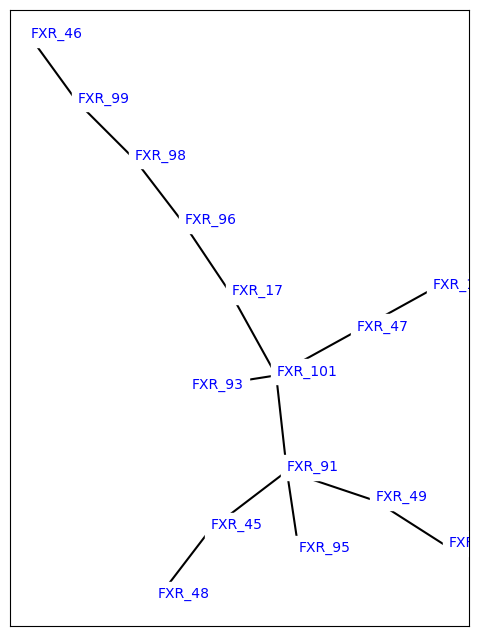

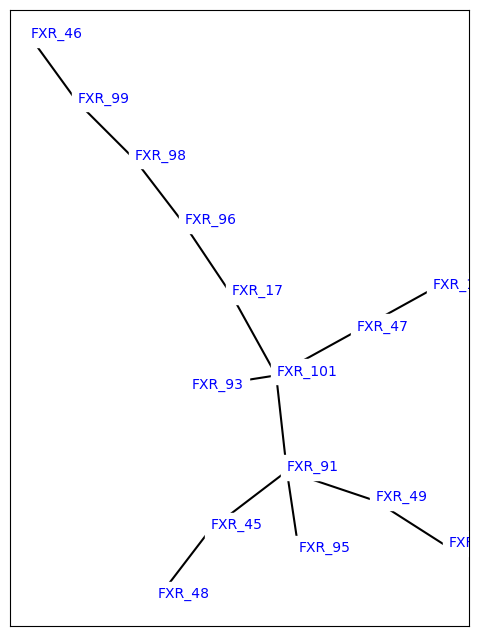

In [5]:
from openfe.utils.atommapping_network_plotting import plot_atommapping_network
plot_atommapping_network(ligand_network)

In [6]:
lomap_mapping = next(mapper.suggest_mappings(ligands[0], ligands[10]))

In [7]:
from kartograf import KartografAtomMapper
# Build Kartograf Atom Mapper
mapper = KartografAtomMapper(atom_map_hydrogens=True)


In [8]:

# Get Mapping
kartograf_mapping = next(mapper.suggest_mappings(ligands[0], ligands[10]))



INFO:	#################################
INFO:	Map Heavy Atoms 
INFO:	#################################
INFO:	Masking Atoms
INFO:	Build Distance Matrix
INFO:	Calculate Mapping
INFO:	Find Maximal overlapping connected sets of mapped atoms
INFO:	#################################
INFO:	Map Hydrogen Atoms: 
INFO:	#################################
INFO:	Masking Atoms
INFO:	Build Distance Matrix
INFO:	Calculate Mapping
INFO:	Find Maximal overlapping connected sets of mapped atoms
INFO:	Filtering bond breaks


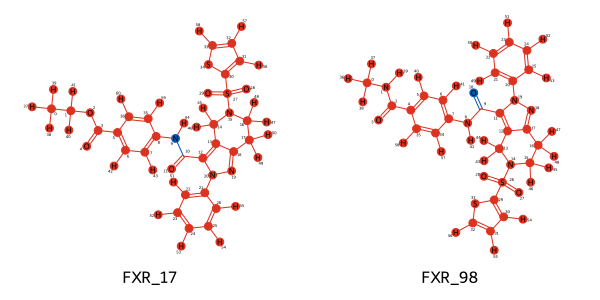

In [9]:
# We can display the atom mapping in 2D by calling it
kartograf_mapping

In [10]:
import openfe
from openfe.setup.ligand_network_planning import generate_minimal_spanning_network

# Create an MST network
mst_network = generate_minimal_spanning_network(
    ligands=ligands,
    scorer=openfe.lomap_scorers.default_lomap_score,
    mappers=[KartografAtomMapper(atom_map_hydrogens=True),])


INFO:	#################################
INFO:	Map Heavy Atoms 
INFO:	#################################
INFO:	Masking Atoms
INFO:	Build Distance Matrix
INFO:	Calculate Mapping
INFO:	Find Maximal overlapping connected sets of mapped atoms
INFO:	#################################
INFO:	Map Hydrogen Atoms: 
INFO:	#################################
INFO:	Masking Atoms
INFO:	Build Distance Matrix
INFO:	Calculate Mapping
INFO:	Find Maximal overlapping connected sets of mapped atoms
INFO:	Filtering bond breaks
INFO:	#################################
INFO:	Map Heavy Atoms 
INFO:	#################################
INFO:	Masking Atoms
INFO:	Build Distance Matrix
INFO:	Calculate Mapping
INFO:	Find Maximal overlapping connected sets of mapped atoms
INFO:	#################################
INFO:	Map Hydrogen Atoms: 
INFO:	#################################
INFO:	Masking Atoms
INFO:	Build Distance Matrix
INFO:	Calculate Mapping
INFO:	Find Maximal overlapping connected sets of mapped atoms
INFO:	Filtering 

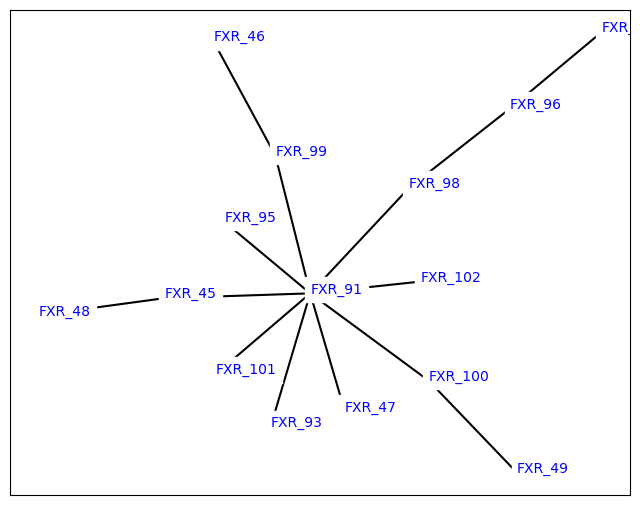

In [11]:
# Visualize the MST network
from openfe.utils.atommapping_network_plotting import plot_atommapping_network

plot_atommapping_network(mst_network)



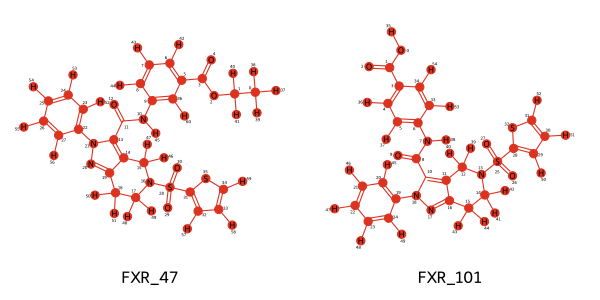

In [12]:
# get the first edge; it automatically displays in a Jupyter notebook
mapping = next(iter(ligand_network.edges))
mapping


In [13]:
# higher score is better
mapping.annotations

{'score': 0.0}

In [14]:
from pathlib import Path
ligand_network_output_path = "./network_setup/"
ligand_network_dir = Path(ligand_network_output_path)
if not ligand_network_dir.exists:
    ligand_network_dir.mkdir(parents=True,exist_ok=True)
try:
    with open("ligand_network_set_1.graphml", mode='w') as f:
        f.write(ligand_network.to_graphml())
except Exception as e:
    print(f"写入ligand_network文件时出错: {e}")

In [15]:

# First let's define the Protein and Solvent Components which we will be using
from openfe import SolventComponent, ProteinComponent
from openff.units import unit

# 暂时屏蔽蛋白质
# protein = ProteinComponent.from_pdb_file('inputs/tyk2_protein.pdb')

# Note: the distance from the solute to add water is not defined here but in the
# the relevant RBFE solver method
solvent = SolventComponent(positive_ion='Na', negative_ion='Cl',
                           neutralize=True, ion_concentration=0.15*unit.molar)

In [16]:
# Let's create the four ChemicalSystems

# systemA = openfe.ChemicalSystem({
#     'ligand': mapping.componentA,
#     'solvent': solvent,
#     },
#     name=mapping.componentA.name
#     )
# systemB = openfe.ChemicalSystem({
#     'ligand': mapping.componentB,
#     'solvent': solvent,
#     },
#     name=mapping.componentB.name
#     )



In [17]:
from openfe.protocols.openmm_rfe import RelativeHybridTopologyProtocol

# Create a protocol for the solvent legs using default settings
solvent_protocol = RelativeHybridTopologyProtocol(RelativeHybridTopologyProtocol.default_settings())

In [18]:
# Here we assume we are creating a transformation for a complex leg
# transformation = openfe.Transformation(
#     systemA,
#     systemB,
#     solvent_protocol,
#     mapping=mapping,
#     name=f"{mapping.componentA.name}_{mapping.componentB.name}_solvent"
# )



In [19]:
transformations = []
for mapping in ligand_network.edges:
    
    # use the solvent and protein created above
    sysA_dict = {'ligand': mapping.componentA,
                    'solvent': solvent}
    sysB_dict = {'ligand': mapping.componentB,
                    'solvent': solvent}


        # If this is a solvent transformation we just use the solvent protocol
    protocol = solvent_protocol

    # we don't have to name objects, but it can make things (like filenames) more convenient
    sysA = openfe.ChemicalSystem(sysA_dict, name=f"{mapping.componentA.name}_ligand")
    sysB = openfe.ChemicalSystem(sysB_dict, name=f"{mapping.componentB.name}_ligand")

    prefix = "rbfe_"  # prefix is only to exactly reproduce CLI

    transformation = openfe.Transformation(
        stateA=sysA,
        stateB=sysB,
        mapping=mapping,
        protocol=protocol,  # use protocol created above
        name=f"{prefix}{sysA.name}_{sysB.name}"
    )
    transformations.append(transformation)

network = openfe.AlchemicalNetwork(transformations)

In [20]:
import pathlib
network_setup_dir = pathlib.Path("./network_setup")
network_setup_dir.mkdir(exist_ok=True)

network.to_json(network_setup_dir / f"network_setup_set_1.json")

In [21]:
import pathlib
# first we create the directory
transformation_dir = pathlib.Path("./network_setup/transformations_set_1")
transformation_dir.mkdir(exist_ok=True)

# then we write out each transformation
for transformation in network.edges:
    transformation.to_json(transformation_dir / f"{transformation.name}.json")

In [24]:
!ls ./network_setup/transformations_set_1

rbfe_FXR_17_ligand_FXR_101_ligand.json	rbfe_FXR_49_ligand_FXR_100_ligand.json
rbfe_FXR_17_ligand_FXR_96_ligand.json	rbfe_FXR_49_ligand_FXR_91_ligand.json
rbfe_FXR_45_ligand_FXR_48_ligand.json	rbfe_FXR_91_ligand_FXR_101_ligand.json
rbfe_FXR_45_ligand_FXR_91_ligand.json	rbfe_FXR_91_ligand_FXR_95_ligand.json
rbfe_FXR_46_ligand_FXR_99_ligand.json	rbfe_FXR_93_ligand_FXR_101_ligand.json
rbfe_FXR_47_ligand_FXR_101_ligand.json	rbfe_FXR_96_ligand_FXR_98_ligand.json
rbfe_FXR_47_ligand_FXR_102_ligand.json	rbfe_FXR_98_ligand_FXR_99_ligand.json


/home/craigv-z/micromamba/envs/openfe/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=33811) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()
